<a href="https://colab.research.google.com/github/paulrobustelli/AR_ligand_binding/blob/main/Setup_OpenMM_MDtraj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:12
🔁 Restarting kernel...


In [1]:
!conda --version


conda 23.11.0


In [2]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!conda install pandas numpy matplotlib


In [ ]:
!conda install -c conda-forge openmm

In [ ]:
!conda install -c conda-forge mdtraj

In [7]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt

## Using Google Drive to store topology data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our topology files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.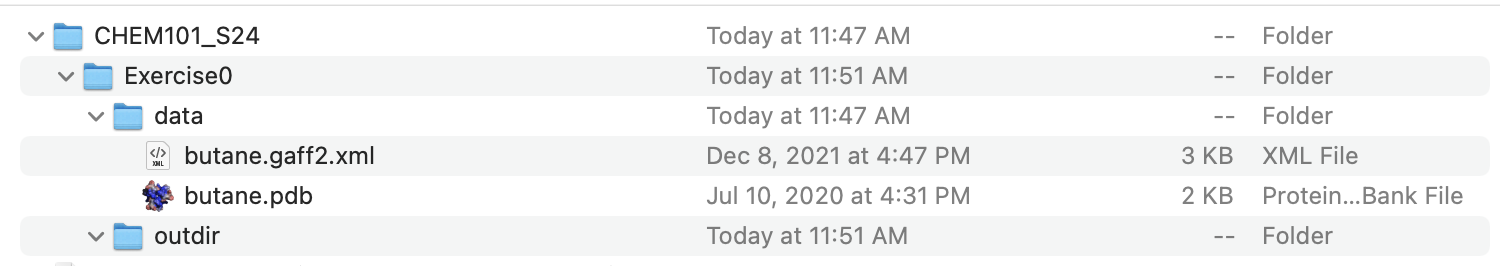

In [8]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


We're going to move our starting materials onto google drive in the subfolder CHEM101_S24/Exercise0

(Drag Folder from slack into into your top directory of google drive)

In [41]:
ls /content/drive/MyDrive/CHEM101_S24/Exercise0/

data/  outdir/


In [42]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt

In [47]:
workdir='/content/drive/MyDrive/CHEM101_S24/Exercise0/'
datadir='/content/drive/MyDrive/CHEM101_S24/Exercise0/data/'
outdir='/content/drive/MyDrive/CHEM101_S24/Exercise0/outdir/'

In [48]:
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

In [49]:
print(PDB_file_name)
print(forcefield_file_name)
print(outdir)

/content/drive/MyDrive/CHEM101_S24/Exercise0/data/butane.pdb
/content/drive/MyDrive/CHEM101_S24/Exercise0/data/butane.gaff2.xml
/content/drive/MyDrive/CHEM101_S24/Exercise0/outdir/


In [50]:
pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

In [51]:
pdb


In [52]:
forcefield


In [57]:
system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

In [58]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127868 kJ/mol
Potential energy after minimization is 5.295271861905617 kJ/mol


In [59]:
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picoseconds, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.295271861905617 kJ/mol
Potential energy after minimization is 5.295054161663413 kJ/mol


In [60]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True,
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,50.886803082147836,254.5350543884704
2000,42.51971621024563,268.950486694197


In [63]:
os.path.join(workdir, "butane_sim.dcd")

'/content/drive/MyDrive/CHEM101_S24/Exercise0/butane_sim.dcd'

In [64]:
#Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,34.17793031680033,278.0301150430276
2000,48.90134158877921,215.53800862579354
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000,
    step=True, time=True, potentialEnergy=True, temperature=True,
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(os.path.join(workdir, "butane_sim.dcd"), 100))
#simulation.reporters.append(app.DCDReporter(outdir+'butane_test.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,27.23473812776021,275.1177672656948,0
500000,999.9999999901769,29.42080998743934,362.3132218492226,7.71e+03
750000,1499.9999999783536,36.31139299683716,352.22148176791165,7.61e+03
1000000,1999.9999999665301,38.08240464157548,316.408116051454,7.3e+03
1250000,2499.9999999547067,45.84173008971814,219.9265124540353,7.46e+03
1500000,2999.9999999428833,57.76730149009859,306.2973088298092,7.35e+03
1750000,3499.99999993106,53.22698194099749,329.4955499206001,7.46e+03
2000000,3999.9999999192364,31.221067972179654,262.33405425212885,7.39e+03
2250000,4499.9999999992715,28.413577522240605,328.67152066958295,7.43e+03
2500000,5000.000000101135,47.606630294180164,278.2868760351603,7.42e+03
2750000,5500.000000202998,29.794679198598764,317.5028220378605,7.38e+03
3000000,6000.000000304862,30.401601309907445,340.47888911879124,7.4e+03
3250000,6500.000000406725,35.189553370317

In [66]:
ls /content/drive/MyDrive/CHEM101_S24/Exercise0/

butane_sim.dcd  data/  outdir/


In [67]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.dcd"), top=PDB_file_name)
traj

<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x7c68d1a9ba30>

In [68]:
atoms, bonds = traj.topology.to_dataframe()
atoms


,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


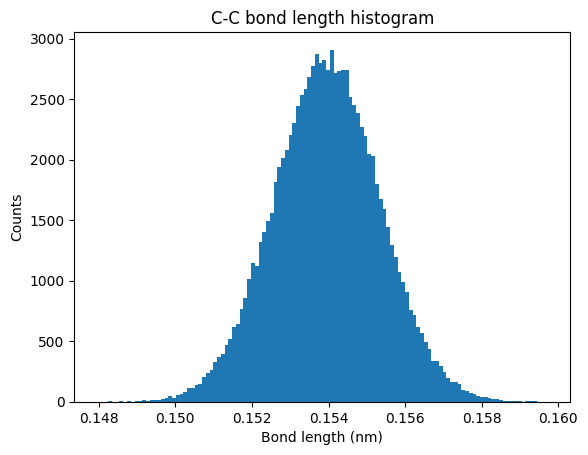

In [69]:
bond_indices = [4, 7] # atoms to define the bond length
bond_length = md.compute_distances(traj, [bond_indices])

bondcounts, binedges, otherstuff = plt.hist(bond_length, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

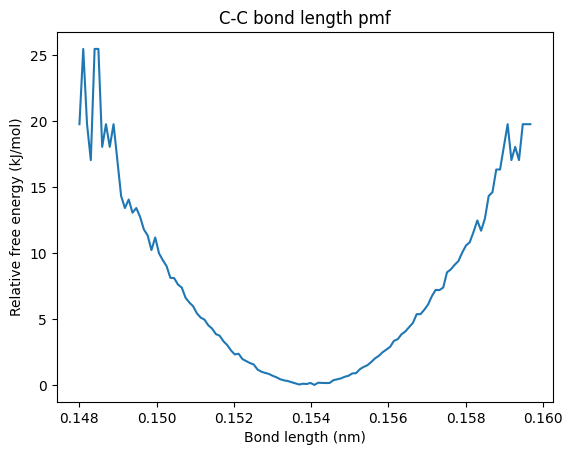

In [70]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
bondcounts[bondcounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(bondcounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-C bond length pmf')
plt.show()

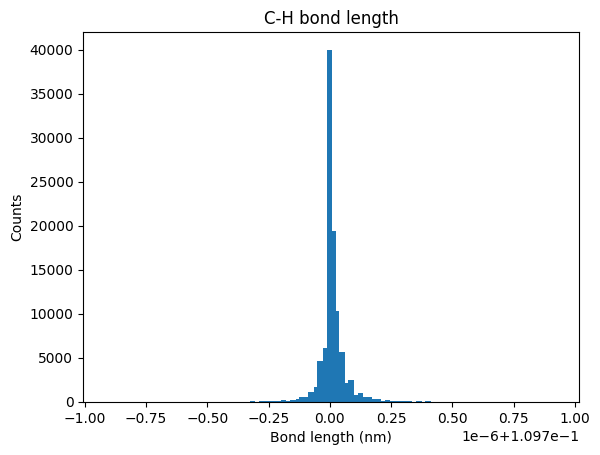

In [71]:
bond_indices = [4, 5] # many possibilities!
bondlength = md.compute_distances(traj, [bond_indices])

lengthcounts, binedges, otherstuff = plt.hist(bondlength, bins=100)
plt.title('C-H bond length')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

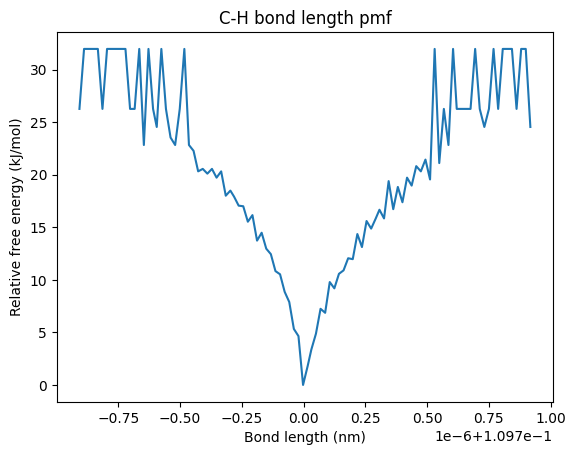

In [72]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
lengthcounts[lengthcounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(lengthcounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-H bond length pmf')
plt.show()

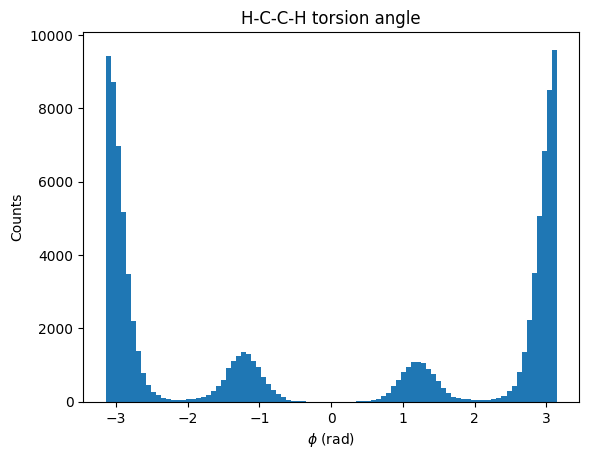

In [73]:
phi_indices = [0, 4, 7, 10] # atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [phi_indices])

phicounts, binedges, otherstuff = plt.hist(phi, bins=90) # create a histogram with 90 bins
plt.title('H-C-C-H torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

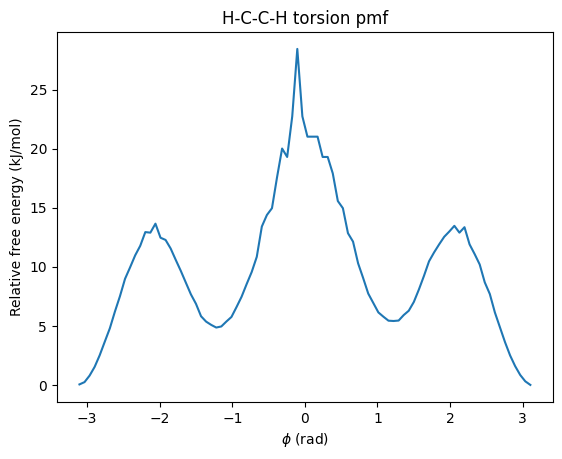

In [74]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('H-C-C-H torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

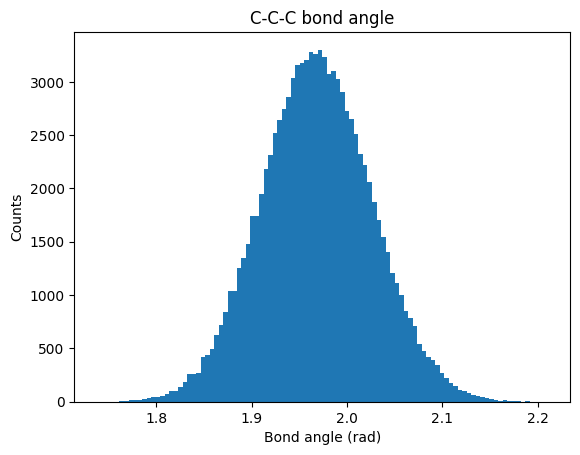

In [75]:
angle_indices = [0, 4, 7] # or could do [4, 7, 10]
bondangle = md.compute_angles(traj, [angle_indices])

anglecounts, binedges, otherstuff = plt.hist(bondangle, bins=100)
plt.title('C-C-C bond angle')
plt.xlabel('Bond angle (rad)')
plt.ylabel('Counts')
plt.show()

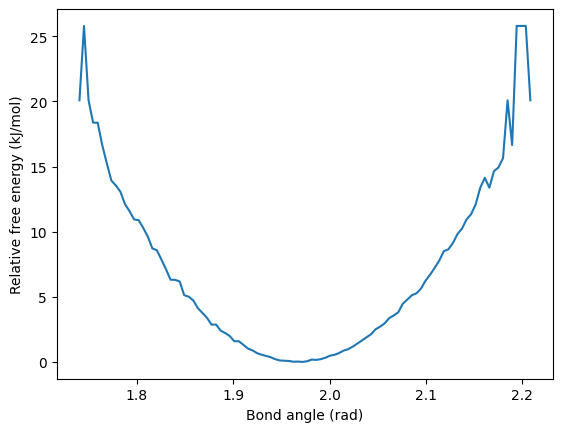

In [76]:
anglecounts[anglecounts==0] = 0.1
pmf = -kB*Temp*np.log(anglecounts)
pmf = pmf - np.min(pmf)

bincenters = (binedges[1:] + binedges[:-1])/2


plt.plot(bincenters, pmf)
plt.xlabel('Bond angle (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()